# Poisson Regression

In [1]:
%run -m ipy_startup
%matplotlib inline
from scipy.stats import poisson

In [49]:
# Generate random data to model
np.random.seed(1)
n, n_var = 10000, 5
#n, n_class, n_var = 10000, 4, 5

X = np.random.randn(n, n_var)

# b_act = .25*np.random.randn(n_var)
# b_int = -.3

b_act = .2*np.array([-.8, -.1, .3, 1.5, 2.5])
b_int = -.3

p = np.exp(b_int + np.dot(X, b_act))

y = np.array([poisson.rvs(v, size=1)[0] for v in p])

X.shape, y.shape

((10000, 5), (10000,))

In [50]:
pd.Series(np.dot(X, b_act)).describe()

count    10000.000000
mean         0.005049
std          0.609639
min         -2.433555
25%         -0.400372
50%          0.000456
75%          0.405720
max          2.253447
dtype: float64

In [51]:
pd.Series(y).value_counts().head()

0    4643
1    3142
2    1383
3     535
4     189
dtype: int64

In [52]:
pd.Series(y).describe()

count    10000.000000
mean         0.888500
std          1.106793
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         10.000000
dtype: float64

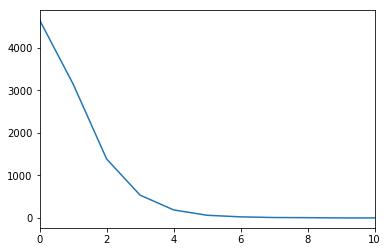

In [53]:
pd.Series(y).value_counts().sort_index().plot()

In [54]:
from ml.scipy import optimize, models
param_names = ['X{}'.format(i) for i in range(n_var)]
constraints = optimize.ScipyConstraints()
constraints.add_gtez('X0')
constraints.add_gte('X1', 'X2')
constraints.add_gte('X2', 'X3')
#constraints.add_gtev('X4', 5.0)

model = (
    models.ScipyPoissonRegressionModelBuilder()
    .add_linear_params(param_names)
    .add_intercept()
    .add_constraints(constraints)
    .build()
)


In [55]:
%%time
est = optimize.ScipyRegressor(model, analytical_gradients=True, monitor_gradient=True, raise_on_failure=False)
est.fit(X, y)

CPU times: user 199 ms, sys: 13.8 ms, total: 212 ms
Wall time: 59.5 ms


In [56]:
print(est.get_fit_summary())

Optimization converged successfully:

    Success: True
    Status Code: 0
    Message: Optimization terminated successfully.
    Number of iterations: 5
    Number of function evaluations: 5
    Objective Function Value: 1.1885639582157117
    


In [57]:
est.get_gradient_error_history()

array([  2.85505105e-08,   3.08586111e-08,   1.33333562e-08,
         2.50080722e-08,   2.50080722e-08])

In [58]:
est.fit_

     fun: 1.1885639582157117
     jac: array([  6.66965565e-05,   1.34325428e-01,   1.28039811e-01,
         4.01910963e-02,  -1.68143718e-01,  -5.30820971e-07])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ -2.58397353e-01,  -2.72985735e-17,   1.24446381e-01,
         1.24446381e-01,   1.24446381e-01,   4.72014306e-01])

In [59]:
d_inf = est.inference()
d_inf

{'intercept': OrderedDict([('intercept', -0.25839735339548398)]), 'linear': OrderedDict([('X0', -2.729857346602916e-17), ('X1', 0.12444638144198575), ('X2', 0.12444638144198568), ('X3', 0.12444638144198572), ('X4', 0.47201430621435775)]), 'fit': OrderedDict()}

In [60]:
b_int, d_inf['intercept']

(-0.3, intercept   -0.258397
 dtype: float64)

In [61]:
b_act

array([-0.16, -0.02,  0.06,  0.3 ,  0.5 ])

In [62]:
def compare(v_est, v_act):
    plt.scatter(v_est, v_act)
    vmin, vmax = v_act.min(), v_act.max()
    plt.xlim(vmin - .1, vmax + .1)
    plt.ylim(vmin - .1, vmax + .1)

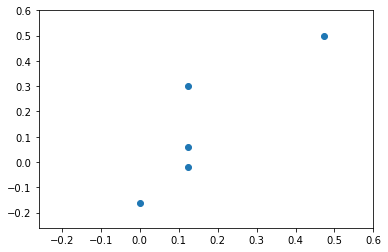

In [63]:
compare(pd.Series(d_inf['linear']), b_act)

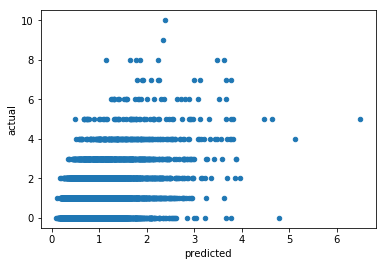

In [64]:
pd.DataFrame({
    'predicted': est.predict(X),
    'actual': y
}).plot(kind='scatter', x='predicted', y='actual')

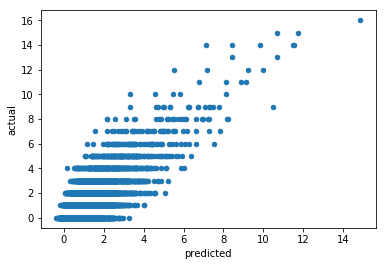

In [57]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
pd.DataFrame({
    'predicted': GradientBoostingRegressor().fit(X, y).predict(X),
    'actual': y
}).plot(kind='scatter', x='predicted', y='actual')